In [73]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from vmtk import pypes
from vmtk import vmtkscripts


base_dir = os.path.abspath('/media/tianyi/data/Analysis/DCM2BIDS5/')
segmentation_dir = os.path.join(base_dir, 'derivatives', 'manualwork', 'segmentations', 'veins_superficial')
output_dir = os.path.join(base_dir, 'derivatives', 'manualwork', 'vmtk_superficial-veins')


In [ ]:

def vmtk_processor(input_fn_pattern, vessel):
    input_nii_fn = os.path.join(segmentation_dir, input_fn_pattern + '_Segmentation-label.nii')
    
    # vmtk: surface extraction
    inSurfaceXtrct = input_nii_fn
    passband = 0.15
    outSurfaceXtrct = os.path.join(output_dir, input_fn_pattern + '_surface.vtp')
    cmdSurfaceXtrct = 'vmtkmarchingcubes -ifile {} -l 0.1 --pipe vmtksurfacesmoothing -passband {} -iterations 30 -ofile {} --pipe vmtksurfaceviewer'.format(inSurfaceXtrct,passband,outSurfaceXtrct)  # input filtered artery
    if not os.path.exists(outSurfaceXtrct):
        pypes.PypeRun(cmdSurfaceXtrct)

    # define filename pattern according to vessel name
    output_fn_pattern = 'sub-' + subject + '_' + vessel

    # vmtk: vessel clipping
    inClipper = outSurfaceXtrct
    outClipper = os.path.join(output_dir, output_fn_pattern + '_openended.vtp')

    if not os.path.exists(outClipper):
        cmdClipper = 'vmtksurfaceclipper -ifile {} -ofile {}'.format(inClipper,outClipper)
        pypes.PypeRun(cmdClipper)

    # vmtk: centerline extraction
    # Uncomment the two lines below and comment current working two to compute centerline using manual selection
    inCenterline = outClipper
    #inCenterline = outSurfaceXtrct
    outCenterline = os.path.join(output_dir, output_fn_pattern + '_centerlines.vtp')
    #cmdCenterline = "vmtksurfacereader -ifile {} --pipe vmtkcenterlines -seedselector openprofiles --pipe vmtkrenderer --pipe vmtksurfaceviewer -opacity 0.25 --pipe vmtksurfaceviewer -i @vmtkcenterlines.o -array DistanceToCenterlines -ofile {}".format(inCenterline,outCenterline)
    cmdCenterline = 'vmtksurfacereader -ifile {} --pipe vmtkcenterlines --pipe vmtkrenderer --pipe vmtksurfaceviewer -opacity 0.25 --pipe vmtksurfaceviewer -i @vmtkcenterlines.o -array DistanceToCenterlines -ofile {}'.format(inCenterline,outCenterline)
    pypes.PypeRun(cmdCenterline)
    
    return outCenterline

def centerline_extractor(outCenterline):

    # centerline reading
    centerlineReader = vmtkscripts.vmtkSurfaceReader()
    centerlineReader.InputFileName = outCenterline
    centerlineReader.Execute()
    clNumpyAdaptor = vmtkscripts.vmtkCenterlinesToNumpy()
    clNumpyAdaptor.Centerlines = centerlineReader.Surface
    clNumpyAdaptor.Execute()
    numpyCenterlines = clNumpyAdaptor.ArrayDict

    points = numpyCenterlines['Points']
    pointsIds = np.arange(len(points))
    radius = numpyCenterlines['PointData']['MaximumInscribedSphereRadius']
    segPointIds = numpyCenterlines['CellData']['CellPointIds']
    numSegments = len(segPointIds)

    frames = []
    for segId in range(numSegments):
        segment = segPointIds[segId]
        segData = pd.DataFrame({'pointId':segment,'segId':segId*np.ones(len(segment), dtype=int),'x':points[segment,0],'y':points[segment,1],'z':points[segment,2],'radius':radius[segment]})
        frames.append(segData)    
    CenterlineData = pd.concat(frames)


    for segId in range(numSegments):
        segment = CenterlineData[CenterlineData['segId'] == segId]

        x = np.array(segment['x'])
        y = np.array(segment['y'])
        z = np.array(segment['z'])

        diff_x = np.diff(x)
        diff_y = np.diff(y)
        diff_z = np.diff(z)

        steplength = np.sqrt(np.square(diff_x) + np.square(diff_y) + np.square(diff_z))
        distance = np.cumsum(steplength)
        distance = np.insert(distance,0,0)

        CenterlineData.loc[CenterlineData['segId'] == segId, 'distance'] = distance

    CenterlineData['diameter'] = 2 * CenterlineData['radius']

    return CenterlineData

In [66]:
subject_list = ['13', '14', '15']
vessel_list = ['LTS', 'SSS', 'RTS']

df_list = []
diameter_df_list = []
for subject in subject_list:
    
    input_fn_pattern = 'sub-' + subject + '_superficial-cortical-veins'
    for vessel in vessel_list:
        output_fn_pattern = 'sub-' + subject + '_' + vessel
        centerline_vtp = os.path.join(output_dir, output_fn_pattern + '_centerlines.vtp')
        if not os.path.exists(centerline_vtp):
            centerline_vtp = vmtk_processor(input_fn_pattern, vessel)
        centerline_df = centerline_extractor(centerline_vtp)
        centerline_df['vessel'] = vessel
        centerline_df['subject'] = subject
        df_list.append(centerline_df)
        
Centerline_SUMMARY = pd.concat(df_list)
#Centerline_SUMMARY_csv = os.path.join(output_dir, 'SUMMARY-centerline_of_veins.csv')
#Centerline_SUMMARY.to_csv(Centerline_SUMMARY_csv, index=False)

Reading VTK XML surface file.
wrapping vtkPolyData object
converting cell data: 
converting points
converting point data: 
MaximumInscribedSphereRadius
EdgeArray
EdgePCoordArray
converting cell connectivity list
Reading VTK XML surface file.
wrapping vtkPolyData object
converting cell data: 
converting points
converting point data: 
MaximumInscribedSphereRadius
EdgeArray
EdgePCoordArray
converting cell connectivity list
Reading VTK XML surface file.
wrapping vtkPolyData object
converting cell data: 
converting points
converting point data: 
MaximumInscribedSphereRadius
EdgeArray
EdgePCoordArray
converting cell connectivity list
Reading VTK XML surface file.
wrapping vtkPolyData object
converting cell data: 
converting points
converting point data: 
MaximumInscribedSphereRadius
EdgeArray
EdgePCoordArray
converting cell connectivity list
Reading VTK XML surface file.
wrapping vtkPolyData object
converting cell data: 
converting points
converting point data: 
MaximumInscribedSphereRadius


In [67]:
Diameter_SUMMARY = Centerline_SUMMARY.copy()
Diameter_SUMMARY.set_index(['subject', 'vessel'], inplace=True)
Diameter_SUMMARY_csv = os.path.join(output_dir, 'SUMMARY-diameter_of_veins.csv')
Diameter_SUMMARY.to_csv(Diameter_SUMMARY_csv)

In [68]:
Diameter_SUMMARY['diameter'].groupby(level=[0,1]).agg(['mean', 'std'])

mean       std
subject vessel                    
13      LTS     7.988047  1.056107
        RTS     4.843618  0.774957
        SSS     5.607083  0.951255
14      LTS     5.305345  0.726310
        RTS     6.439986  0.522046
        SSS     5.660931  1.283370
15      LTS     4.940044  1.065985
        RTS     7.652803  1.260188
        SSS     5.720435  1.178379

In [69]:
Diameter_SUMMARY['distance'].groupby(level=[0,1]).agg(['max'])

max
subject vessel            
13      LTS      89.268608
        RTS      96.746277
        SSS     220.748444
14      LTS     101.690018
        RTS      98.547379
        SSS     223.738998
15      LTS     143.472046
        RTS     114.931007
        SSS     232.926743

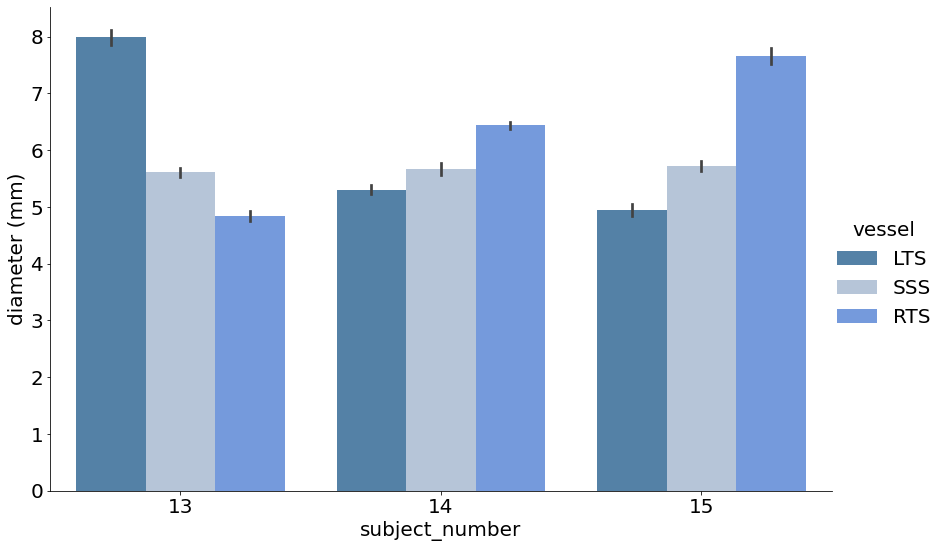

In [94]:
sns_plot = sns.catplot(x='subject',
                       y='diameter',
                       hue='vessel',
                       kind='bar',
                       palette=['steelblue', 'lightsteelblue', 'cornflowerblue'],
                       height=8,
                       aspect=6/4,
                       data=Centerline_SUMMARY)
sns_plot.set_axis_labels('subject_number', 'diameter (mm)')
matplotlib.rcParams.update({'font.size': 20})

figure_path = os.path.join(output_dir, 'SUMMARY-diameter_of_veins_Plot.png')
plt.savefig(figure_path,dpi=300)